In [1]:
import numpy as np

In [2]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
from tqdm import tqdm

In [1]:
import sys

root = '../../'
sys.path.append(root)
from HelpfulFunctions.batchCreation import createBatch

In [3]:
X_train = np.load( root + "Features/train_features_vgg16_cifar10.npy" )
y_train = np.load( root + "Features/train_labels_vgg16_cifar10.npy" )

X_test = np.load( root + "Features/test_features_vgg16_cifar10.npy" )
y_test = np.load( root + "Features/test_labels_vgg16_cifar10.npy" )

In [4]:
X_train.shape

(45000, 4096)

----

In [5]:
bits = 32

margin = int(bits / 10)
sample_size = len(X_train)
batchSize = 40

In [6]:
model = nn.Sequential(  nn.Linear(4096,256),
                        nn.ReLU(),
                        nn.Linear(256, bits),
                        nn.Sigmoid()
                        )

optimizer = optim.Adam( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

In [7]:
toTensor = transforms.ToTensor()


xSub = X_train[:sample_size]
ySub = y_train[:sample_size]

xTensor = toTensor(xSub)
xTensor.shape

torch.Size([1, 45000, 4096])

In [8]:
negative_i_dict = {}

for label in set(ySub):
    negative_i_dict[label] = [i for i in range(len(ySub)) if ySub[i] != label ]

------

In [9]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if (posDist < dMatrix[a][i]) and (dMatrix[a][i] <= posDist+margin)] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [10]:
xTensor.shape

torch.Size([1, 45000, 4096])

In [11]:
xTensor[0].shape

torch.Size([45000, 4096])

In [12]:
loss_list = []
for i in tqdm( range(5000) ):

    batch_i = random.sample(range(sample_size), batchSize)

    xBatch = torch.stack( [xTensor[0][j] for j in batch_i] )
    yBatch = [ySub[j] for j in batch_i]

    results = model(xBatch)
    results_np = results.detach().numpy()


    dMatrix = distance_matrix(results_np, results_np, p=1)

    APN_list = []

    for label in set(yBatch):
        pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]

        for anchor_i in pos_i_list:
            pos_i = [j for j in pos_i_list if j != anchor_i]

            APN_list += getAPN(anchor_i, pos_i, dMatrix)

    if len(APN_list) > 0:
        a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list),
                        torch.stack(p_list),
                        torch.stack(n_list) )
        
        loss.backward()
        optimizer.step()

        loss_list.append( float(loss) )

    if (i % 200) == 0: 
        #print(f"Make Bacthes + get results: {t2-t1}\n", f"Distance Matrix: {t3-t2}\n", f"MAke APN List: {t4-t3}\n", f"Back Propegate: {t5-t4}")
        
        if len(loss_list) != 0: print(i, sum(loss_list) / len(loss_list) )
        else: print(i, "Done")
        loss_list = []


  0%|          | 9/5000 [00:00<01:46, 46.95it/s]

0 2.954991102218628


  4%|▍         | 211/5000 [00:02<01:03, 75.84it/s]

200 2.1770448726415634


  8%|▊         | 411/5000 [00:05<00:56, 81.81it/s]

400 2.0159977400302886


 12%|█▏        | 611/5000 [00:07<00:54, 80.19it/s]

600 1.9624380391836167


 16%|█▌        | 810/5000 [00:10<01:12, 57.80it/s]

800 1.9629430669546126


 20%|██        | 1013/5000 [00:13<00:57, 69.35it/s]

1000 1.9495117223262788


 24%|██▍       | 1214/5000 [00:16<00:54, 69.19it/s]

1200 1.9287207758426665


 28%|██▊       | 1411/5000 [00:19<00:50, 70.47it/s]

1400 1.9465935081243515


 32%|███▏      | 1610/5000 [00:22<00:46, 72.27it/s]

1600 1.938087757229805


 36%|███▌      | 1810/5000 [00:25<00:44, 71.12it/s]

1800 1.9393418338894843


 40%|████      | 2009/5000 [00:28<00:42, 71.04it/s]

2000 1.91748255610466


 44%|████▍     | 2209/5000 [00:30<00:40, 69.49it/s]

2200 1.8891179692745208


 48%|████▊     | 2414/5000 [00:33<00:37, 69.72it/s]

2400 1.9079253256320954


 52%|█████▏    | 2609/5000 [00:36<00:33, 71.65it/s]

2600 1.8957458996772767


 56%|█████▌    | 2809/5000 [00:39<00:29, 73.74it/s]

2800 1.9323079419136047


 60%|██████    | 3013/5000 [00:42<00:28, 70.85it/s]

3000 1.903094129562378


 64%|██████▍   | 3209/5000 [00:44<00:24, 71.96it/s]

3200 1.9448346507549286


 68%|██████▊   | 3409/5000 [00:47<00:21, 72.49it/s]

3400 1.9054674917459489


 72%|███████▏  | 3615/5000 [00:50<00:19, 70.01it/s]

3600 1.8896668946743012


 76%|███████▌  | 3811/5000 [00:53<00:16, 71.88it/s]

3800 1.9021218794584274


 80%|████████  | 4011/5000 [00:56<00:13, 74.19it/s]

4000 1.8993828392028809


 84%|████████▍ | 4211/5000 [00:59<00:11, 71.24it/s]

4200 1.9276022678613662


 88%|████████▊ | 4411/5000 [01:01<00:08, 72.07it/s]

4400 1.9011587077379226


 92%|█████████▏| 4611/5000 [01:04<00:05, 69.97it/s]

4600 1.9067125952243804


 96%|█████████▌| 4809/5000 [01:07<00:02, 72.08it/s]

4800 1.9342856478691102


100%|██████████| 5000/5000 [01:10<00:00, 71.29it/s]


----

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

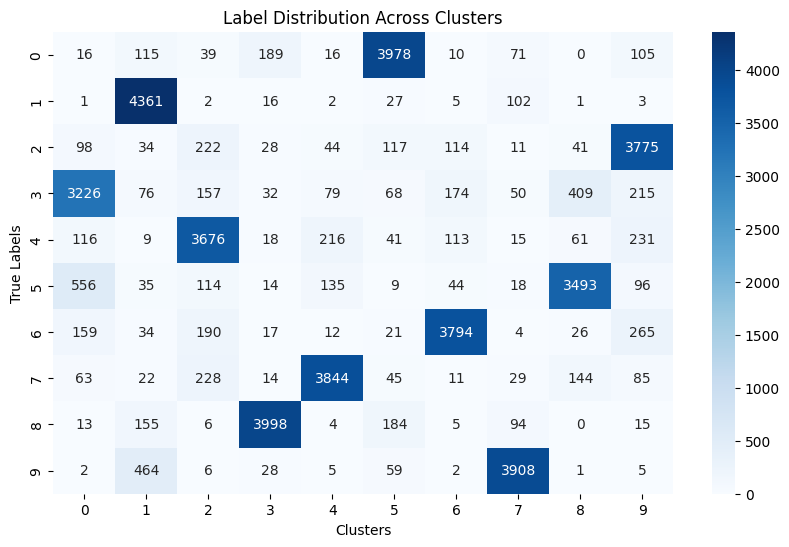

In [14]:
easyHeatmap(model(xTensor).detach().numpy()[0], ySub)

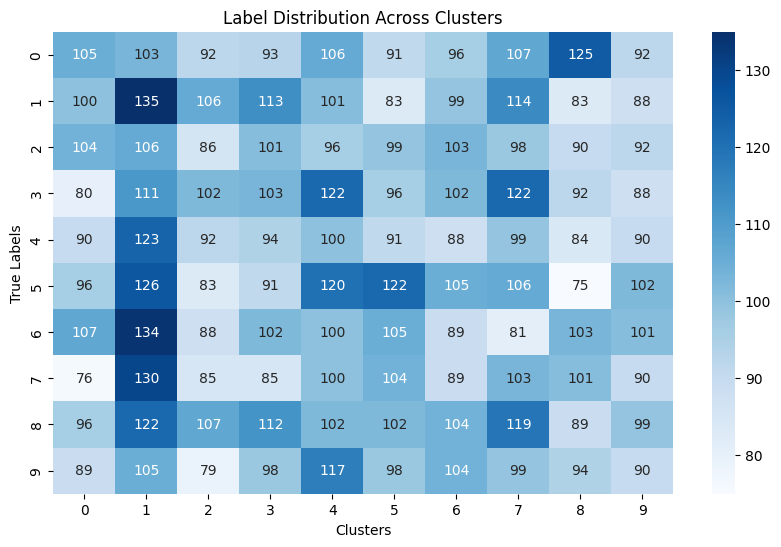

In [15]:
X_test_tensor = toTensor(X_test)
easyHeatmap(model(X_test_tensor).detach().numpy()[0], ySub)

In [16]:
def mean_average_precision(test_hashes, labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = labels[i]
        distances = np.abs(test_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.drop(index=i)
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [17]:
res = (model(X_test_tensor).detach().numpy()[0] > 0.5).astype(int)
mean_average_precision( res , y_test)

100%|██████████| 10000/10000 [00:43<00:00, 228.20it/s]


0.7312751836932928